In [1]:
# Show graphs inline, as part of the notebook
%matplotlib inline

# Show graphs in a separate window
#%matplotlib osx
#%matplotlib qt  # wx, gtk, osx, tk
#%matplotlib # empty uses default

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
import time
import os
import glob
import random
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # disables GPU, keras will use CPU instead.

# http://www.numpy.org
import numpy as np

# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html
import matplotlib.pyplot as pp

# Multidimensional matrix multiplications
#import tensorflow as tf

# Convenient API for describing neural networks
import keras as k
from keras.utils import np_utils

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#from sklearn.utils import class_weight

# Reading/writing datasets from/to file 
import h5py

# https://github.com/jiaaro/pydub
from pydub import AudioSegment
from pydub.playback import play

# local library of helpful functions
import library as lib
from importlib import reload
library = reload(lib)

Using TensorFlow backend.


AhemPreventor library load success.
AhemPreventor library load success.


C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:184: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


## Let's keep number of epochs and batch_size the same for all networks for better comparability

In [2]:
NUM_EPOCHS = 30
BATCH_SIZE = 256

## Loading Samples

In [3]:
#folderToUse = "PrecomputedSpectra"
folderToUse = "PrecomputedSpecialFeatures"

allPositivesFileNames = glob.glob(folderToUse + "/*-positives.npy")
allNegativesFileNames = glob.glob(folderToUse + "/*-negatives.npy")

# hand-annotated positives
positives = []
for filename in allPositivesFileNames:
    # print(lecture)
    p = np.load(filename)
    print("positive file", filename, " has shape ", p.shape)
    positives.append(p)

# random negatives (at positions where there are no positives)
negatives = []
for filename in allNegativesFileNames:
    # print(lecture)
    p = np.load(filename)
    print("negative file", filename, " has shape ", p.shape)
    negatives.append(p)
    
# aggregate lists to numpy arrays
positives = np.vstack(positives)
print("positives shape:", positives.shape)
negatives = np.vstack(negatives)
print("negatives shape:", negatives.shape)

# Now we have X positive samples, each of them is multiplied by positivesMultiplier (see 01-ExtractFeatures notebook), 
# so we get positivesMultiplier*sampleId sequentially after each other
# We need to pick sets of positivesMultiplier from each speaker of the set so we have data from all speakers.
# We must make sure not to pick the same positive sample with different noise ratios into both training and validation set!
positivesMultiplier = library.positivesMultiplier
validationSplit = 0.25   # 25% as validation data

pos_train = []
pos_val = []

neg_train = []
neg_val =[]

# stepSize is positivesMultiplier to prevent the same positive sample in both training and validation set.
for i in range(0, len(positives), positivesMultiplier):
    if random.uniform(0.0, 1.0) > validationSplit:
        for j in range(i, i+positivesMultiplier):
            pos_train.append(positives[j])
            neg_train.append(negatives[j])
    else:
        for j in range(i, i+positivesMultiplier):
            pos_val.append(positives[j])
            neg_val.append(negatives[j])
    
# free some memory for those of us with little RAM...
del positives
del negatives

x_train = np.vstack((pos_train, neg_train))
y_train = np.array([1] * len(pos_train) + [0] * len(neg_train)) # labels (1 or 0)
print("train shapes: ", x_train.shape, y_train.shape)

x_val = np.vstack((pos_val, neg_val))
y_val = np.array([1] * len(pos_val) + [0] * len(neg_val)) # labels (1 or 0)
print("val shapes: ", x_val.shape, y_val.shape)


# randomly permute samples
indices = np.random.permutation(len(x_train))
#print(indices)
x_train = x_train[indices]
y_train = y_train[indices]
print("train.shapes:", x_train.shape, y_train.shape)

# randomly permute samples
indices = np.random.permutation(len(x_val))
#print(indices)
x_val = x_val[indices]
y_val = y_val[indices]
print("val.shapes:", x_val.shape, y_val.shape)

# free some memory for those of us with little RAM...
del pos_train, neg_train, pos_val, neg_val


positive file PrecomputedSpecialFeatures\speaker-0-Vorlesung-01.wav-positives.npy  has shape  (6275, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-0-Vorlesung-02.wav-positives.npy  has shape  (5775, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-0-Vorlesung-03.wav-positives.npy  has shape  (5525, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-0-Vorlesung-04.wav-positives.npy  has shape  (5175, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-1-Uebung-01.wav-positives.npy  has shape  (2200, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-1-Uebung-02.wav-positives.npy  has shape  (4450, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-1-Uebung-03.wav-positives.npy  has shape  (2775, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-2-Uebung-06.wav-positives.npy  has shape  (1350, 49, 40)
positive file PrecomputedSpecialFeatures\speaker-2-Uebung-07.wav-positives.npy  has shape  (800, 49, 40)
positive file PrecomputedSpecialFea

## Simple Dense nets as baseline

In [4]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)

x = tf.keras.layers.Flatten()(x)
print(x)

outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "simpleDense1Layer"

Tensor("input:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("flatten/Identity:0", shape=(None, 1960), dtype=float32)
Tensor("output/Identity:0", shape=(None, 1), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 40)            160       
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 1961      
Total params: 2,121
Trainable params: 2,041
Non-trainable params: 80
_________________________________________________________________

In [5]:
history1 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 3s 50us/sample - loss: 0.2914 - accuracy: 0.8767 - false_positive_rate: 0.1531 - true_positive_rate: 0.9396 - val_loss: 0.2729 - val_accuracy: 0.8901 - val_false_positive_rate: 0.0765 - val_true_positive_rate: 0.8509
Epoch 2/30
55600/55600 [==============================] - 2s 27us/sample - loss: 0.1218 - accuracy: 0.9612 - false_positive_rate: 0.0524 - true_positive_rate: 0.9767 - val_loss: 0.3048 - val_accuracy: 0.8890 - val_false_positive_rate: 0.0659 - val_true_positive_rate: 0.8371
Epoch 3/30
55600/55600 [==============================] - 2s 28us/sample - loss: 0.0973 - accuracy: 0.9709 - false_positive_rate: 0.0437 - true_positive_rate: 0.9871 - val_loss: 0.3665 - val_accuracy: 0.8815 - val_false_positive_rate: 0.0550 - val_true_positive_rate: 0.8101
Epoch 4/30
55600/55600 [==============================] - 2s 28us/sample - loss: 0.0851 - accuracy: 0.9747 - false_positive_r

55600/55600 [==============================] - 1s 26us/sample - loss: 0.0523 - accuracy: 0.9837 - false_positive_rate: 0.0224 - true_positive_rate: 0.9898 - val_loss: 0.8675 - val_accuracy: 0.8372 - val_false_positive_rate: 0.0533 - val_true_positive_rate: 0.7147


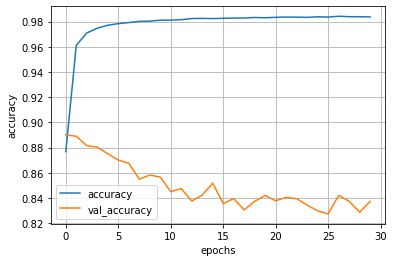

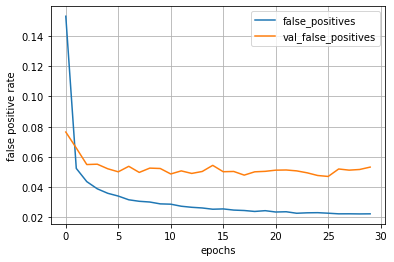

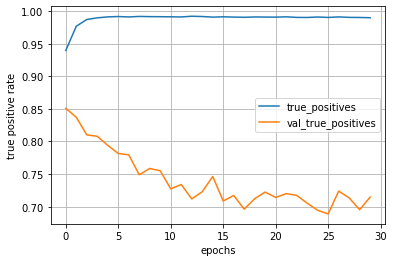

In [6]:
library.show_history(history1)

In [7]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)

x = tf.keras.layers.Flatten()(x)
print(x)

x = tf.keras.layers.Dropout(0.2)(x)
print(x)

x = tf.keras.layers.Dense(1024, activation="sigmoid")(x)
print(x)

x = tf.keras.layers.Dropout(0.2)(x)
print(x)

x = tf.keras.layers.Dense(64, activation="sigmoid")(x)
print(x)

x = tf.keras.layers.Dropout(0.2)(x)
print(x)

outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "simpleDense3Layers"

Tensor("input_1:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_1/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("flatten_1/Identity:0", shape=(None, 1960), dtype=float32)
Tensor("dropout/Identity:0", shape=(None, 1960), dtype=float32)
Tensor("dense/Identity:0", shape=(None, 1024), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(None, 1024), dtype=float32)
Tensor("dense_1/Identity:0", shape=(None, 64), dtype=float32)
Tensor("dropout_2/Identity:0", shape=(None, 64), dtype=float32)
Tensor("output_1/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 40)            160       
_________________________________________________________________
flat

In [8]:
history1_1 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 3s 49us/sample - loss: 0.1458 - accuracy: 0.9472 - false_positive_rate: 0.0635 - true_positive_rate: 0.9587 - val_loss: 0.3653 - val_accuracy: 0.8959 - val_false_positive_rate: 0.0521 - val_true_positive_rate: 0.8380
Epoch 2/30
55600/55600 [==============================] - 2s 32us/sample - loss: 0.0733 - accuracy: 0.9765 - false_positive_rate: 0.0298 - true_positive_rate: 0.9835 - val_loss: 0.4499 - val_accuracy: 0.8837 - val_false_positive_rate: 0.0375 - val_true_positive_rate: 0.7986
Epoch 3/30
55600/55600 [==============================] - 2s 32us/sample - loss: 0.0438 - accuracy: 0.9871 - false_positive_rate: 0.0164 - true_positive_rate: 0.9903 - val_loss: 0.4811 - val_accuracy: 0.8834 - val_false_positive_rate: 0.0292 - val_true_positive_rate: 0.7908
Epoch 4/30
55600/55600 [==============================] - 2s 32us/sample - loss: 0.0274 - accuracy: 0.9928 - false_positive_r

55600/55600 [==============================] - 2s 33us/sample - loss: 0.0074 - accuracy: 0.9989 - false_positive_rate: 1.3969e-04 - true_positive_rate: 0.9980 - val_loss: 0.5671 - val_accuracy: 0.8771 - val_false_positive_rate: 0.0127 - val_true_positive_rate: 0.7642


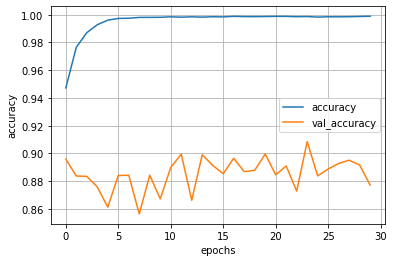

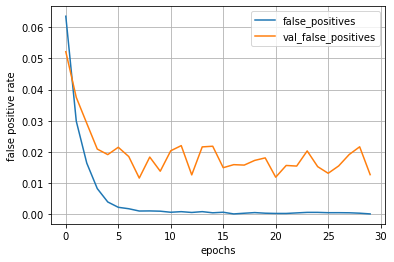

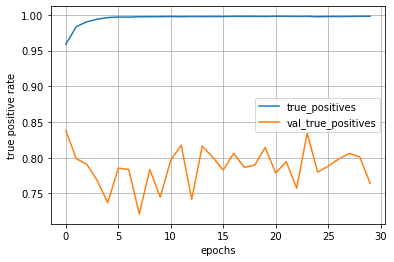

In [9]:
library.show_history(history1_1)

## one layer GRU

In [10]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)


x = tf.keras.layers.GRU(40, 
                return_sequences = False, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "1layerGRU"

Tensor("input_2:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_2/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("gru/Identity:0", shape=(None, 40), dtype=float32)
Tensor("output_2/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 49, 40)            160       
_________________________________________________________________
gru (GRU)                    (None, 40)                9840      
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 10,041
Trainable params: 9,961
Non-trainable params: 80
______________________________________________________________

In [11]:
history2 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 22s 402us/sample - loss: 0.5367 - accuracy: 0.7201 - false_positive_rate: 0.2738 - true_positive_rate: 0.7153 - val_loss: 0.3908 - val_accuracy: 0.8257 - val_false_positive_rate: 0.1548 - val_true_positive_rate: 0.7988
Epoch 2/30
55600/55600 [==============================] - 19s 341us/sample - loss: 0.3452 - accuracy: 0.8528 - false_positive_rate: 0.1453 - true_positive_rate: 0.8516 - val_loss: 0.2554 - val_accuracy: 0.8957 - val_false_positive_rate: 0.0810 - val_true_positive_rate: 0.8682
Epoch 3/30
55600/55600 [==============================] - 20s 353us/sample - loss: 0.2504 - accuracy: 0.8990 - false_positive_rate: 0.1023 - true_positive_rate: 0.9017 - val_loss: 0.2036 - val_accuracy: 0.9271 - val_false_positive_rate: 0.0532 - val_true_positive_rate: 0.9052
Epoch 4/30
55600/55600 [==============================] - 19s 344us/sample - loss: 0.1952 - accuracy: 0.9258 - false_po

55600/55600 [==============================] - 16s 295us/sample - loss: 0.0348 - accuracy: 0.9888 - false_positive_rate: 0.0137 - true_positive_rate: 0.9912 - val_loss: 0.0875 - val_accuracy: 0.9699 - val_false_positive_rate: 0.0136 - val_true_positive_rate: 0.9530


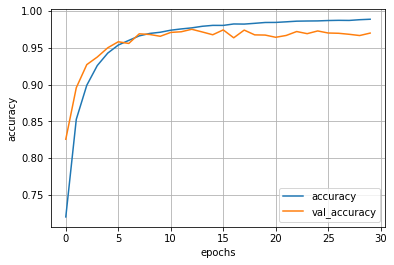

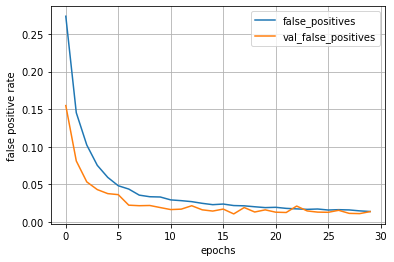

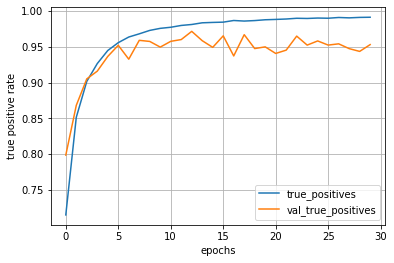

In [12]:
library.show_history(history2)

## one layer LSTM

In [13]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)


x = tf.keras.layers.LSTM(40, 
                return_sequences = False, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "1layerLSTM"

Tensor("input_3:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_3/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("lstm/Identity:0", shape=(None, 40), dtype=float32)
Tensor("output_3/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 49, 40)            160       
_________________________________________________________________
lstm (LSTM)                  (None, 40)                12960     
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 13,161
Trainable params: 13,081
Non-trainable params: 80
____________________________________________________________

In [14]:
history2_1 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 19s 340us/sample - loss: 0.4272 - accuracy: 0.7981 - false_positive_rate: 0.2003 - true_positive_rate: 0.8079 - val_loss: 0.2373 - val_accuracy: 0.9059 - val_false_positive_rate: 0.0913 - val_true_positive_rate: 0.9026
Epoch 2/30
55600/55600 [==============================] - 16s 290us/sample - loss: 0.2296 - accuracy: 0.9116 - false_positive_rate: 0.0903 - true_positive_rate: 0.9140 - val_loss: 0.1857 - val_accuracy: 0.9303 - val_false_positive_rate: 0.0406 - val_true_positive_rate: 0.8985
Epoch 3/30
55600/55600 [==============================] - 16s 288us/sample - loss: 0.1742 - accuracy: 0.9354 - false_positive_rate: 0.0669 - true_positive_rate: 0.9373 - val_loss: 0.1691 - val_accuracy: 0.9428 - val_false_positive_rate: 0.0325 - val_true_positive_rate: 0.9165
Epoch 4/30
55600/55600 [==============================] - 16s 286us/sample - loss: 0.1442 - accuracy: 0.9478 - false_po

55600/55600 [==============================] - 16s 287us/sample - loss: 0.0337 - accuracy: 0.9895 - false_positive_rate: 0.0133 - true_positive_rate: 0.9923 - val_loss: 0.1556 - val_accuracy: 0.9621 - val_false_positive_rate: 0.0113 - val_true_positive_rate: 0.9349


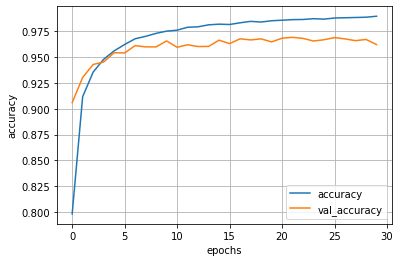

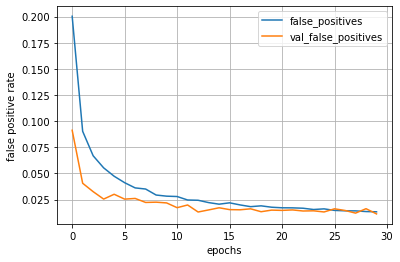

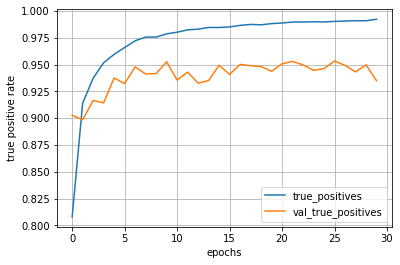

In [15]:
library.show_history(history2_1)

## Two layer GRU

In [16]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)


x = tf.keras.layers.GRU(40, 
                return_sequences = True, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

x = tf.keras.layers.GRU(16, 
                return_sequences=False,
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)


outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "2layerGRU"

Tensor("input_4:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_4/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("gru_1/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("gru_2/Identity:0", shape=(None, 16), dtype=float32)
Tensor("output_4/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 49, 40)            160       
_________________________________________________________________
gru_1 (GRU)                  (None, 49, 40)            9840      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2784      
_________________________________________________________________


In [17]:
history3 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 34s 608us/sample - loss: 0.5322 - accuracy: 0.7251 - false_positive_rate: 0.2674 - true_positive_rate: 0.7180 - val_loss: 0.3749 - val_accuracy: 0.8385 - val_false_positive_rate: 0.1426 - val_true_positive_rate: 0.8126
Epoch 2/30
55600/55600 [==============================] - 30s 534us/sample - loss: 0.3296 - accuracy: 0.8606 - false_positive_rate: 0.1383 - true_positive_rate: 0.8596 - val_loss: 0.2573 - val_accuracy: 0.8936 - val_false_positive_rate: 0.0756 - val_true_positive_rate: 0.8575
Epoch 3/30
55600/55600 [==============================] - 30s 544us/sample - loss: 0.2303 - accuracy: 0.9099 - false_positive_rate: 0.0920 - true_positive_rate: 0.9132 - val_loss: 0.1738 - val_accuracy: 0.9343 - val_false_positive_rate: 0.0461 - val_true_positive_rate: 0.9125
Epoch 4/30
55600/55600 [==============================] - 29s 525us/sample - loss: 0.1719 - accuracy: 0.9352 - false_po

55600/55600 [==============================] - 29s 523us/sample - loss: 0.0340 - accuracy: 0.9892 - false_positive_rate: 0.0142 - true_positive_rate: 0.9924 - val_loss: 0.0678 - val_accuracy: 0.9770 - val_false_positive_rate: 0.0139 - val_true_positive_rate: 0.9676


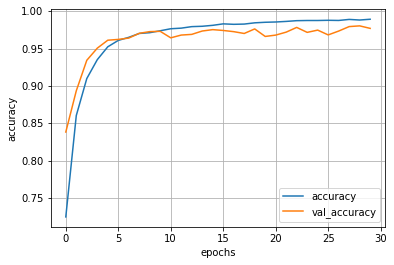

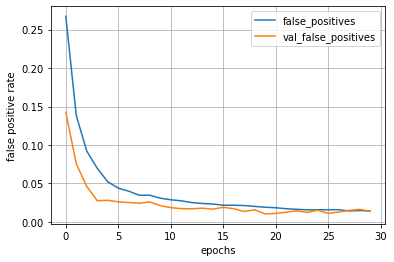

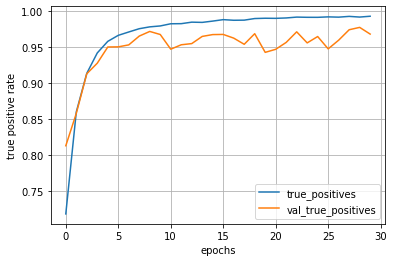

In [18]:
library.show_history(history3)

## Two layer GRU large

In [19]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)


x = tf.keras.layers.GRU(80, 
                return_sequences = True, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

x = tf.keras.layers.GRU(32, 
                return_sequences=False,
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)


outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "2layerGRULarge"

Tensor("input_5:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_5/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("gru_3/Identity:0", shape=(None, 49, 80), dtype=float32)
Tensor("gru_4/Identity:0", shape=(None, 32), dtype=float32)
Tensor("output_5/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 49, 40)            160       
_________________________________________________________________
gru_3 (GRU)                  (None, 49, 80)            29280     
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                10944     
_________________________________________________________________


In [20]:
history4 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 33s 585us/sample - loss: 0.4242 - accuracy: 0.8002 - false_positive_rate: 0.1943 - true_positive_rate: 0.7967 - val_loss: 0.2335 - val_accuracy: 0.9043 - val_false_positive_rate: 0.0687 - val_true_positive_rate: 0.8733
Epoch 2/30
55600/55600 [==============================] - 29s 524us/sample - loss: 0.1910 - accuracy: 0.9287 - false_positive_rate: 0.0760 - true_positive_rate: 0.9341 - val_loss: 0.1207 - val_accuracy: 0.9567 - val_false_positive_rate: 0.0392 - val_true_positive_rate: 0.9524
Epoch 3/30
55600/55600 [==============================] - 28s 510us/sample - loss: 0.1196 - accuracy: 0.9571 - false_positive_rate: 0.0472 - true_positive_rate: 0.9622 - val_loss: 0.1049 - val_accuracy: 0.9655 - val_false_positive_rate: 0.0236 - val_true_positive_rate: 0.9543
Epoch 4/30
55600/55600 [==============================] - 28s 506us/sample - loss: 0.0866 - accuracy: 0.9699 - false_po

55600/55600 [==============================] - 28s 506us/sample - loss: 0.0174 - accuracy: 0.9948 - false_positive_rate: 0.0068 - true_positive_rate: 0.9963 - val_loss: 0.1519 - val_accuracy: 0.9613 - val_false_positive_rate: 0.0095 - val_true_positive_rate: 0.9317


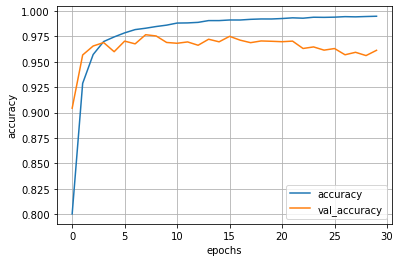

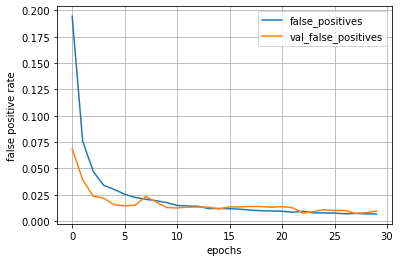

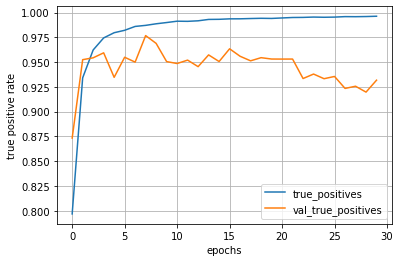

In [21]:
library.show_history(history4)

## Three layer GRU

In [22]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)


x = tf.keras.layers.GRU(40, 
                return_sequences = True, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

x = tf.keras.layers.GRU(12, 
                return_sequences = True, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

x = tf.keras.layers.GRU(4, 
                return_sequences = False, 
                stateful = False,
                dropout=0.0, recurrent_dropout=0.0)(x)
print(x)

outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "3layerGRU"

Tensor("input_6:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_6/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("gru_5/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("gru_6/Identity:0", shape=(None, 49, 12), dtype=float32)
Tensor("gru_7/Identity:0", shape=(None, 4), dtype=float32)
Tensor("output_6/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 49, 40)            160       
_________________________________________________________________
gru_5 (GRU)                  (None, 49, 40)            9840      
_________________________________________________________________
gru_6 (GRU)                  (None, 49, 12)            1944      
___

In [23]:
history5 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 37s 672us/sample - loss: 0.5158 - accuracy: 0.7442 - false_positive_rate: 0.2505 - true_positive_rate: 0.7359 - val_loss: 0.3705 - val_accuracy: 0.8505 - val_false_positive_rate: 0.1322 - val_true_positive_rate: 0.8277
Epoch 2/30
55600/55600 [==============================] - 30s 536us/sample - loss: 0.3166 - accuracy: 0.8759 - false_positive_rate: 0.1239 - true_positive_rate: 0.8761 - val_loss: 0.2162 - val_accuracy: 0.9210 - val_false_positive_rate: 0.0861 - val_true_positive_rate: 0.9300
Epoch 3/30
55600/55600 [==============================] - 30s 533us/sample - loss: 0.2095 - accuracy: 0.9244 - false_positive_rate: 0.0786 - true_positive_rate: 0.9286 - val_loss: 0.1365 - val_accuracy: 0.9520 - val_false_positive_rate: 0.0466 - val_true_positive_rate: 0.9508
Epoch 4/30
55600/55600 [==============================] - 30s 534us/sample - loss: 0.1524 - accuracy: 0.9460 - false_po

55600/55600 [==============================] - 31s 554us/sample - loss: 0.0313 - accuracy: 0.9900 - false_positive_rate: 0.0127 - true_positive_rate: 0.9926 - val_loss: 0.0911 - val_accuracy: 0.9701 - val_false_positive_rate: 0.0128 - val_true_positive_rate: 0.9525


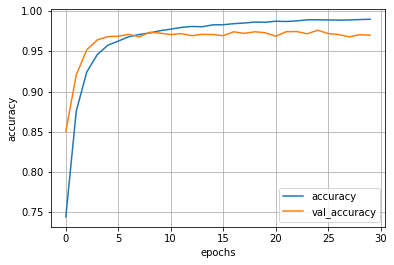

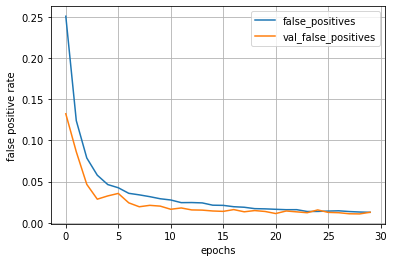

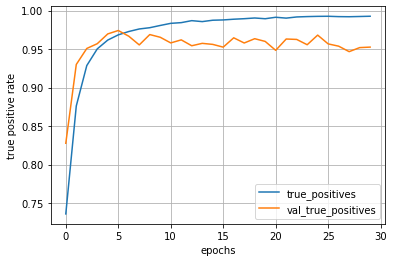

In [24]:
library.show_history(history5)

## Three layer LSTM

In [25]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols), name="input")
print(inputs)
x = inputs

x = tf.keras.layers.BatchNormalization()(x)
print(x)


x = tf.keras.layers.LSTM(40, 
                return_sequences = True, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

x = tf.keras.layers.LSTM(12, 
                return_sequences = True, 
                stateful = False,
                dropout=0.2, recurrent_dropout=0.2)(x)
print(x)

x = tf.keras.layers.LSTM(4, 
                return_sequences = False, 
                stateful = False,
                dropout=0.0, recurrent_dropout=0.0)(x)
print(x)

outputs = tf.keras.layers.Dense(1, name="output", activation="sigmoid")(x)
print(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "3layerLSTM"

Tensor("input_7:0", shape=(None, 49, 40), dtype=float32)
Tensor("batch_normalization_7/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("lstm_1/Identity:0", shape=(None, 49, 40), dtype=float32)
Tensor("lstm_2/Identity:0", shape=(None, 49, 12), dtype=float32)
Tensor("lstm_3/Identity:0", shape=(None, 4), dtype=float32)
Tensor("output_7/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 49, 40)]          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 49, 40)            160       
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 40)            12960     
_________________________________________________________________
lstm_2 (LSTM)                (None, 49, 12)            2544      


In [26]:
history6 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 38s 676us/sample - loss: 0.4424 - accuracy: 0.8353 - false_positive_rate: 0.1616 - true_positive_rate: 0.8325 - val_loss: 0.2665 - val_accuracy: 0.9187 - val_false_positive_rate: 0.0948 - val_true_positive_rate: 0.9356
Epoch 2/30
55600/55600 [==============================] - 31s 563us/sample - loss: 0.2296 - accuracy: 0.9271 - false_positive_rate: 0.0680 - true_positive_rate: 0.9220 - val_loss: 0.1497 - val_accuracy: 0.9623 - val_false_positive_rate: 0.0451 - val_true_positive_rate: 0.9704
Epoch 3/30
55600/55600 [==============================] - 32s 569us/sample - loss: 0.1603 - accuracy: 0.9501 - false_positive_rate: 0.0509 - true_positive_rate: 0.9519 - val_loss: 0.1184 - val_accuracy: 0.9677 - val_false_positive_rate: 0.0391 - val_true_positive_rate: 0.9752
Epoch 4/30
55600/55600 [==============================] - 31s 563us/sample - loss: 0.1257 - accuracy: 0.9619 - false_po

55600/55600 [==============================] - 33s 590us/sample - loss: 0.0252 - accuracy: 0.9922 - false_positive_rate: 0.0099 - true_positive_rate: 0.9945 - val_loss: 0.0869 - val_accuracy: 0.9741 - val_false_positive_rate: 0.0119 - val_true_positive_rate: 0.9597


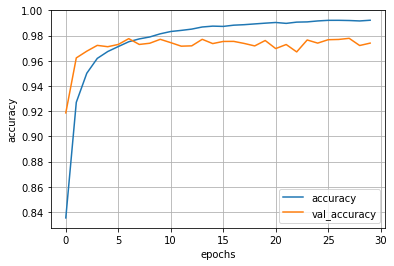

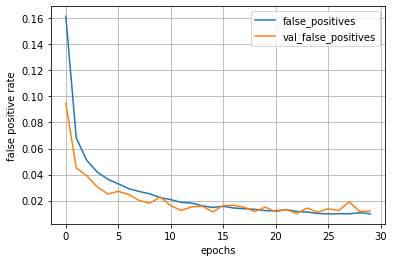

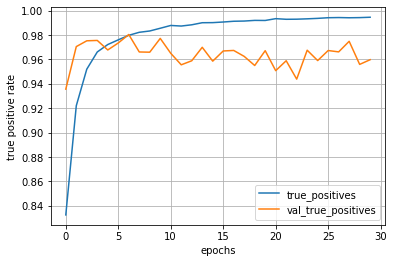

In [27]:
library.show_history(history6)

# Now let's try some CNNs

In [28]:
# gotta reshape our data first
x_train = x_train.reshape(len(x_train), x_train.shape[1], x_train.shape[2], 1)
y_train = y_train.reshape(len(y_train), 1)

x_val = x_val.reshape(len(x_val), x_val.shape[1], x_val.shape[2], 1)
y_val = y_val.reshape(len(y_val), 1)

## Two filter layers Conv2D

In [29]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols, 1))
print(inputs)
x = inputs

x = tf.keras.layers.Dropout(0.2)(x)
print(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(rows, 3), strides=1, padding="valid", activation="relu")(x)
print(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1,17), strides=2, padding="valid", activation="relu")(x)
print(x)

x = tf.keras.layers.MaxPooling2D(pool_size = (1,2), strides = (1,2))(x)
print(x)

x = tf.keras.layers.Flatten()(x)
print(x)

x = tf.keras.layers.Dense(14, activation='relu')(x)
print(x)

x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
print(x)

outputs = x
model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "CNN_oneFilterLayer"

Tensor("input_1_1:0", shape=(None, 49, 40, 1), dtype=float32)
Tensor("dropout_3/Identity:0", shape=(None, 49, 40, 1), dtype=float32)
Tensor("conv2d/Identity:0", shape=(None, 1, 38, 32), dtype=float32)
Tensor("conv2d_1/Identity:0", shape=(None, 1, 11, 16), dtype=float32)
Tensor("max_pooling2d/Identity:0", shape=(None, 1, 5, 16), dtype=float32)
Tensor("flatten_2/Identity:0", shape=(None, 80), dtype=float32)
Tensor("dense_2/Identity:0", shape=(None, 14), dtype=float32)
Tensor("dense_3/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 40, 1)]       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 38, 32)         

In [30]:
history7 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 2s 44us/sample - loss: 0.1808 - accuracy: 0.9252 - false_positive_rate: 0.0762 - true_positive_rate: 0.9269 - val_loss: 0.1572 - val_accuracy: 0.9441 - val_false_positive_rate: 0.0464 - val_true_positive_rate: 0.9339
Epoch 2/30
55600/55600 [==============================] - 2s 27us/sample - loss: 0.0524 - accuracy: 0.9833 - false_positive_rate: 0.0213 - true_positive_rate: 0.9882 - val_loss: 0.1914 - val_accuracy: 0.9367 - val_false_positive_rate: 0.0235 - val_true_positive_rate: 0.8949
Epoch 3/30
55600/55600 [==============================] - 1s 27us/sample - loss: 0.0350 - accuracy: 0.9885 - false_positive_rate: 0.0142 - true_positive_rate: 0.9913 - val_loss: 0.2103 - val_accuracy: 0.9398 - val_false_positive_rate: 0.0258 - val_true_positive_rate: 0.9036
Epoch 4/30
55600/55600 [==============================] - 1s 25us/sample - loss: 0.0245 - accuracy: 0.9924 - false_positive_r

55600/55600 [==============================] - 1s 26us/sample - loss: 0.0065 - accuracy: 0.9976 - false_positive_rate: 0.0026 - true_positive_rate: 0.9979 - val_loss: 0.6531 - val_accuracy: 0.9181 - val_false_positive_rate: 0.0150 - val_true_positive_rate: 0.8489


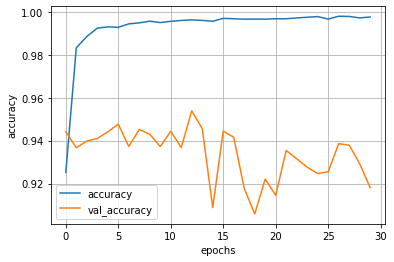

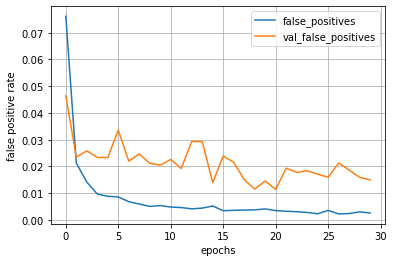

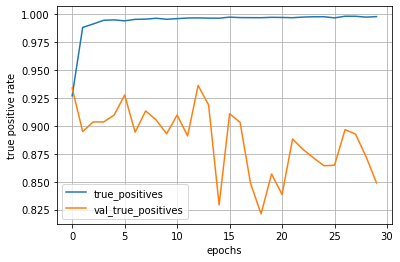

In [31]:
library.show_history(history7)

## CNN 2 - more dropout and pooling

In [32]:
rows, cols = x_train.shape[1:3]
inputs = tf.keras.layers.Input(shape=(rows, cols, 1))
print(inputs)
x = inputs

x = tf.keras.layers.Dropout(0.3)(x)
print(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(rows, 3), strides=1, padding="valid", activation="relu")(x)
print(x)

x = tf.keras.layers.MaxPooling2D(pool_size = (1,2), strides = (1,2))(x)
print(x)

x = tf.keras.layers.Dropout(0.3)(x)
print(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1,17), strides=2, padding="valid", activation="relu")(x)
print(x)

x = tf.keras.layers.MaxPooling2D(pool_size = (1,2), strides = (1,2))(x)
print(x)

x = tf.keras.layers.Dropout(0.3)(x)
print(x)

x = tf.keras.layers.Flatten()(x)
print(x)

x = tf.keras.layers.Dense(14, activation='relu')(x)
print(x)

x = tf.keras.layers.Dropout(0.3)(x)
print(x)

x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
print(x)

outputs = x
model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(lr=0.001)
print(opt)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', library.false_positive_rate, library.true_positive_rate])
model.summary()

modelName = "CNN_twoFilterLayers_extraDropout"

Tensor("input_2_1:0", shape=(None, 49, 40, 1), dtype=float32)
Tensor("dropout_4/Identity:0", shape=(None, 49, 40, 1), dtype=float32)
Tensor("conv2d_2/Identity:0", shape=(None, 1, 38, 32), dtype=float32)
Tensor("max_pooling2d_1/Identity:0", shape=(None, 1, 19, 32), dtype=float32)
Tensor("dropout_5/Identity:0", shape=(None, 1, 19, 32), dtype=float32)
Tensor("conv2d_3/Identity:0", shape=(None, 1, 2, 16), dtype=float32)
Tensor("max_pooling2d_2/Identity:0", shape=(None, 1, 1, 16), dtype=float32)
Tensor("dropout_6/Identity:0", shape=(None, 1, 1, 16), dtype=float32)
Tensor("flatten_3/Identity:0", shape=(None, 16), dtype=float32)
Tensor("dense_4/Identity:0", shape=(None, 14), dtype=float32)
Tensor("dropout_7/Identity:0", shape=(None, 14), dtype=float32)
Tensor("dense_5/Identity:0", shape=(None, 1), dtype=float32)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(Non

In [33]:
history8 = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val))
model.save("models/model-"+modelName+".h5")

Train on 55600 samples, validate on 18900 samples
Epoch 1/30
55600/55600 [==============================] - 2s 42us/sample - loss: 0.5317 - accuracy: 0.7322 - false_positive_rate: 0.2669 - true_positive_rate: 0.7459 - val_loss: 0.2323 - val_accuracy: 0.9083 - val_false_positive_rate: 0.1158 - val_true_positive_rate: 0.9402
Epoch 2/30
55600/55600 [==============================] - 1s 27us/sample - loss: 0.2763 - accuracy: 0.8942 - false_positive_rate: 0.1065 - true_positive_rate: 0.8952 - val_loss: 0.1730 - val_accuracy: 0.9351 - val_false_positive_rate: 0.0937 - val_true_positive_rate: 0.9708
Epoch 3/30
55600/55600 [==============================] - 1s 26us/sample - loss: 0.2202 - accuracy: 0.9196 - false_positive_rate: 0.0820 - true_positive_rate: 0.9224 - val_loss: 0.1625 - val_accuracy: 0.9396 - val_false_positive_rate: 0.0877 - val_true_positive_rate: 0.9729
Epoch 4/30
55600/55600 [==============================] - 1s 26us/sample - loss: 0.1872 - accuracy: 0.9338 - false_positive_r

55600/55600 [==============================] - 1s 26us/sample - loss: 0.1131 - accuracy: 0.9625 - false_positive_rate: 0.0429 - true_positive_rate: 0.9687 - val_loss: 0.1137 - val_accuracy: 0.9621 - val_false_positive_rate: 0.0509 - val_true_positive_rate: 0.9768


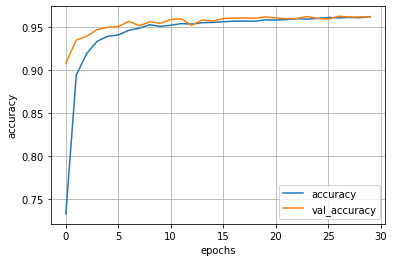

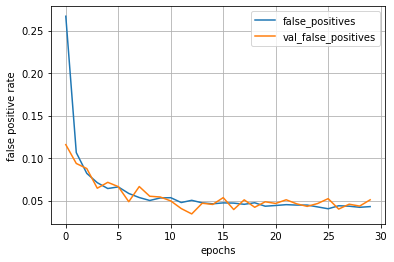

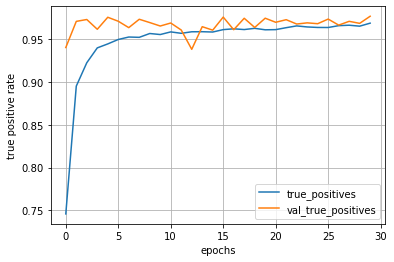

In [34]:
library.show_history(history8)